In [444]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import re
import string
import seaborn as sns

#For visualizations
import os
from wordcloud import WordCloud, STOPWORDS
from os import path, getcwd
from PIL import Image

from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

from nltk import word_tokenize
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('en')

stop_words = stopwords.words('english')

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn #remove unnecessary warnings

In [ ]:
train = pd.read_csv('../Unsuper Capstone/spooky/train.csv')

### This data set contains sentences from 3 authors' novels in the horror genre

Eap: Edgar Allen Poe, MWS: Mary Shelley, HPL: H.P Lovecraft

In [442]:
#Quick look at Author distribution 
train.author.value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [443]:
#Lets get are data ready for some visualizations!

eap = train[train.author=="EAP"]["text"].values
hpl = train[train.author=="HPL"]["text"].values
mws = train[train.author=="MWS"]["text"].values

In [445]:
#Set photo masks for wordcloud creation
#get data directory 
d = getcwd()

frank = np.array(Image.open(path.join(d, "frank.png")))
squid = np.array(Image.open(path.join(d, "octo.png")))
raven = np.array(Image.open(path.join(d, "raven.png")))

## Let's visualize each Author's common words!

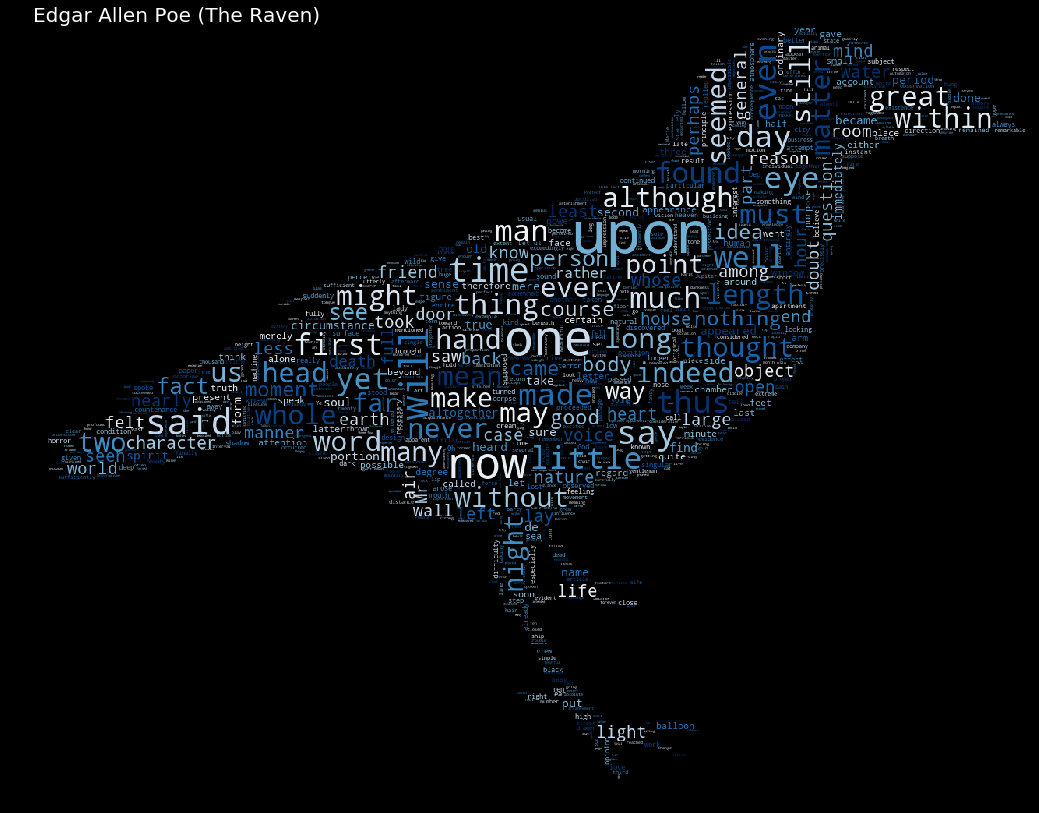

In [448]:
# The wordcloud of a raven for Mr Edgar Allen Poe
style.use('dark_background')
plt.figure(figsize=(18,14))

wc = WordCloud(background_color="black", max_words=1000, 
               mask=raven, stopwords=STOPWORDS, max_font_size= 75)
wc.generate(" ".join(eap))
plt.title("Edgar Allen Poe (The Raven)", loc='left', fontsize=20)

plt.imshow(wc.recolor( colormap = 'Blues_r' , random_state=17), alpha=0.98)
plt.axis('off')
plt.show()

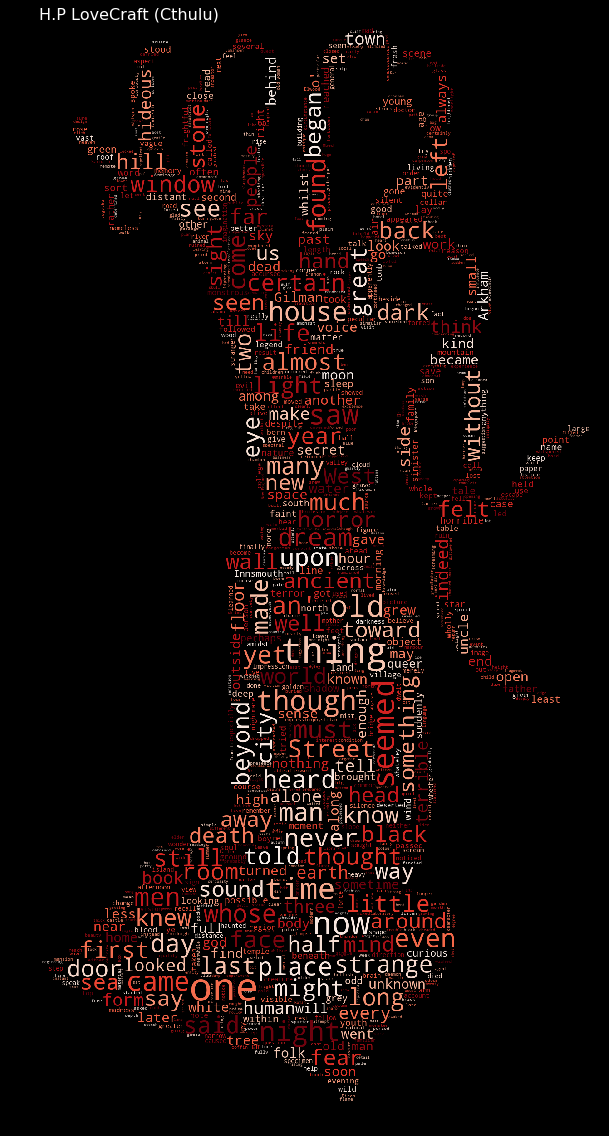

In [449]:
# The wordcloud of Cthulhu monster for HP Lovecraft
style.use('dark_background')
plt.figure(figsize=(20,20))

wc = WordCloud(background_color="black", max_words=1000, 
               mask=squid, stopwords=STOPWORDS, max_font_size= 85, random_state=17)
wc.generate(" ".join(hpl))
plt.title("H.P LoveCraft (Cthulu)", loc='left', fontsize=16)

plt.imshow(wc.recolor( colormap = 'Reds_r' , random_state=17), alpha=0.98)
plt.axis('off')
plt.show()

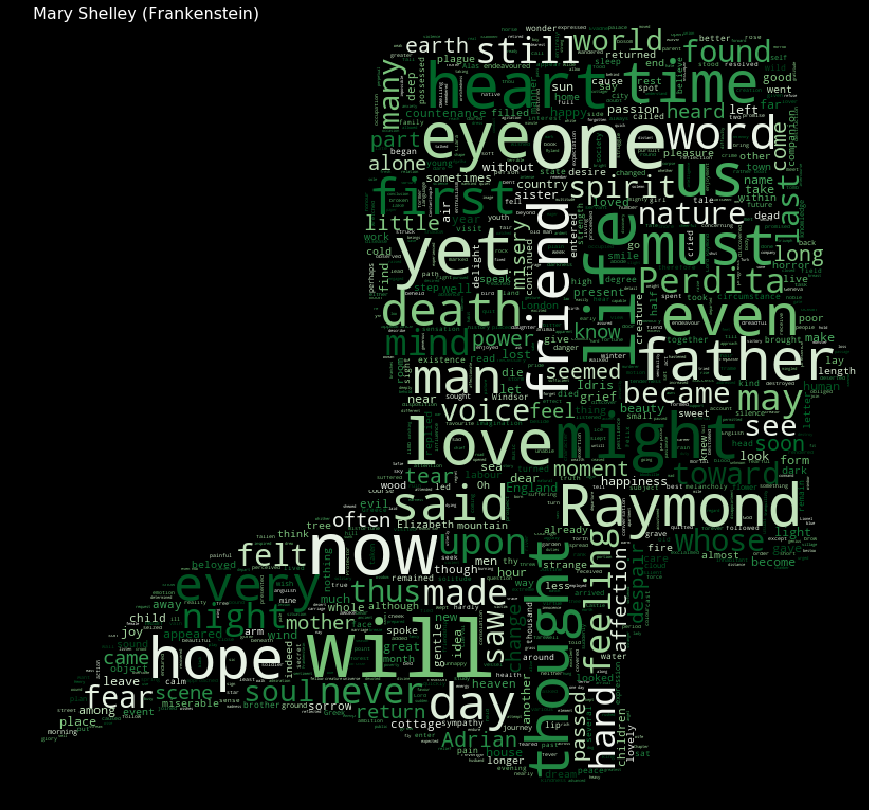

In [451]:
# The wordcloud of Frankenstein, Mary Shelley
plt.figure(figsize=(18,14))
style.use('dark_background')

wc = WordCloud(background_color="black", max_words=1000, 
               mask=frank, stopwords=STOPWORDS, max_font_size=75, random_state=17)
wc.generate(" ".join(mws))
plt.title("Mary Shelley (Frankenstein)", loc='left', fontsize=16)

plt.imshow(wc.recolor(colormap = 'Greens_r', random_state=17), alpha=0.98)
plt.axis('off')
plt.show()

### Now that we have some nice pictures we can go deeper into the data!

### Our data at a glance

In [300]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


### Let's predict the author using a very rough supervised learning benchmark 
We'll use unsupervised learning on 'test' (no labels just text)

We're looking at the horror novel genre:

Authors are Edgar Allen Poe (EAP), Mary Shelley(MWS), and HP Lovecraft(HPL)

In [301]:
#Use label encoder to label authors 0, 1, 2

lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(train.author.values)
x = train.text.values

In [302]:
#Lets use train/test split

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                  stratify=y,
                                                  test_size=0.1, shuffle=True)

#Check shapes
print(x_train.shape)
print(x_test.shape)

(17621,)
(1958,)


### Evaluating different models 

In [304]:
tfv = TfidfVectorizer(max_features=None,
                      min_df=3, strip_accents='unicode', analyzer='word',
                      token_pattern=r'\w{1,}',
                      stop_words='english', ngram_range=(1, 3), use_idf=1, 
                      sublinear_tf=1, 
                      lowercase=True, #convert everything to lower case 
                      norm=u'l2', #Long vs Short paragraphs treated equally
                      smooth_idf=1) 

#Fit and reshape our data with tf-idf

tfv.fit(list(x_train) + list(x_test)) #semi-supervised
xtrain_tfv =  tfv.transform(x_train)
xtest_tfv = tfv.transform(x_test)

In [305]:
#We'll make our evaluator, a multiclass logloss function

def multiclass_logloss(actual, predicted, eps=1e-15):
    """Multi class version of Logarithmic Loss metric.
    :param actual: Array containing the actual target classes
    :param predicted: Matrix with class predictions, one probability per class
    """
    # Convert 'actual' to a binary array if it's not already:
    if len(actual.shape) == 1:
        actual2 = np.zeros((actual.shape[0], predicted.shape[1]))
        for i, val in enumerate(actual):
            actual2[i, val] = 1
        actual = actual2

    clip = np.clip(predicted, eps, 1 - eps)
    rows = actual.shape[0]
    vsota = np.sum(actual * np.log(clip))
    return -1.0 / rows * vsota

### Logistic Regression, the first model

In [308]:
#First model, a simple Logistic Regression
log = LogisticRegression(C=1.0)
log.fit(xtrain_tfv, y_train)

y_pred = log.predict_proba(xtest_tfv)

print('Training accuracy LogRegr is: %0.2f' % (log.score(xtrain_tfv, y_train)))
print('Test accuracy LogRegr is: %0.2f' % (log.score(xtest_tfv, y_test)))

scores = cross_val_score(log, xtrain_tfv, y_train, cv=5)
print("Cross Val LogRegr Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print ("\nlogloss: %0.3f " % multiclass_logloss(y_test, y_pred))


Training accuracy LogRegr is: 0.90
Test accuracy LogRegr is: 0.81
Cross Val LogRegr Accuracy: 0.79 (+/- 0.01)


logloss: 0.608 


### A simple NaiveBayes model

In [310]:
# Fitting a simple Naive Bayes on TFIDF

nb = MultinomialNB()
nb.fit(xtrain_tfv, y_train)

y_pred1 = nb.predict_proba(xtest_tfv)

print('Training accuracy NaiveBayes is: %0.2f' % (nb.score(xtrain_tfv, y_train)))
print('Test accuracy NaiveBayes is: %0.2f' % (nb.score(xtest_tfv, y_test)))

scores = cross_val_score(nb, xtrain_tfv, y_train, cv=5)
print("Cross Val NaiveBayes Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print ("\nlogloss: %0.3f " % multiclass_logloss(y_test, y_pred1))

Training accuracy NaiveBayes is: 0.91
Test accuracy NaiveBayes is: 0.83
Cross Val NaiveBayes Accuracy: 0.82 (+/- 0.00)


logloss: 0.559 


### Finally, a SVM model
SVM models are quite intensive and don't handle a massive amount of features very well, for this reason we will be lowering the number of features via TruncatedSVD

In [312]:
# Apply SVD, I chose 120 components. 120-200 components are good enough for SVM model
#We need to reduce the number of features before running an svd model

svd = decomposition.TruncatedSVD(n_components=120)
svd.fit(xtrain_tfv)
xtrain_svd = svd.transform(xtrain_tfv)
xtest_svd = svd.transform(xtest_tfv)

# Scale the data obtained from SVD. Renaming variable to reuse without scaling.
scl = preprocessing.StandardScaler()
scl.fit(xtrain_svd)
xtrain_svd_scl = scl.transform(xtrain_svd)
xtest_svd_scl = scl.transform(xtest_svd)

# Fitting a simple SVM
lvm = SVC(C=1.0, probability=True) # since we need probabilities

lvm.fit(xtrain_svd_scl, y_train)
y_pred2 = lvm.predict_proba(xtest_svd_scl)

In [313]:
#SVM Scores
print('Training accuracy SVM is: %0.2f' % (lvm.score(xtrain_svd_scl, y_train)))
print('Test accuracy SVM is: %0.2f' % (lvm.score(xtest_svd_scl, y_test)))

scores = cross_val_score(lvm, xtrain_svd_scl, y_train, cv=3)
print("Cross Val SVM Accuracy: %0.2f (+/- %0.2f)\n" % (scores.mean(), scores.std() * 2))

print ("\nlogloss: %0.3f " % multiclass_logloss(y_test, y_pred2))

Training accuracy SVM is: 0.81
Test accuracy SVM is: 0.71
Cross Val SVM Accuracy: 0.68 (+/- 0.01)


logloss: 0.684 


### Out of all our models a simple NaiveBayes model worked best!
Looks like the old and simple models are still applicable even today!!

### Now let's observe how Unsupervised learning performs
I will manually clean the data here to ensure it's just as clean as I want it while giving the models the best chance at performing well

In [315]:
#Lets do some text cleaning

from nltk import sent_tokenize
from nltk.stem.porter import PorterStemmer

spoo = train.text.to_string()
porter = PorterStemmer()
table = str.maketrans('', '', string.punctuation)
stop_words = stopwords.words('english')

start = re.sub(r'\d+', '', spoo) #remove numbers
start1 = start.replace("\n", "") #remove the '\n'
start2 = " ".join(start1.split()) #remove duplicate whitespace
sentences = sent_tokenize(start2) #tokenize our sentences
lower = [word.lower() for word in sentences] #make all lowercase
stripped = [w.translate(table) for w in lower] #remove punctuation
stripped = [w for w in stripped if not w in stop_words] #remove stop words
final = [porter.stem(word) for word in stripped] #apply stem words


In [321]:
#Perform our train/test split
X_train, X_test = train_test_split(final, test_size=0.25, random_state=0)

#Build the vectorizor
vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case 
                             use_idf=True,
                             norm=u'l2', #Long vs short sentences treated equally
                             smooth_idf=True)

#Applying the vectorizer to our cleaned data

final_tfidf = vectorizer.fit_transform(final)
print("Number of features: %d" % final_tfidf.get_shape()[1])

Number of features: 7694


In [322]:
#splitting vectorized data into training and test sets
X_train_tfidf, X_test_tfidf = train_test_split(final_tfidf, test_size=0.25)

#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

n = X_train_tfidf_csr.shape[0]

#A list of dictionaries, one per sent
tfidf_bypara = [{} for _ in range(0,n)]

#List of features
terms = vectorizer.get_feature_names()

#for each sentence, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train[5])
print('Tf_idf vector:', tfidf_bypara[5])

Original sentence: i earned that i deserved it
Tf_idf vector: {'death': 0.5432153618847229, 'evident': 0.6569633962673945, 'far': 0.5227964867682836}


In [319]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

#Our SVD data reducer.  We are going to reduce the feature space from 7694 to 130.
svd= TruncatedSVD(130)
lsa = make_pipeline(svd, Normalizer(copy=False))

# Run SVD on the training data, then project the training data.
X_train_lsa = lsa.fit_transform(X_train_tfidf)

variance_explained=svd.explained_variance_ratio_
total_variance = variance_explained.sum()
print("Percent variance captured by all components:",total_variance*100)

#Looking at what sorts of Sentences our solution considers similar 
#for the first five identified topics

sent_by_component = pd.DataFrame(X_train_lsa, index=X_train)

for i in range(5):
    print('Component {}:'.format(i))
    print(sent_by_component.loc[:,i].sort_values(ascending=False)[0:6])

Percent variance captured by all components: 15.725924340505115
Component 0:
it was in the latter end of september that i a                                                  0.717499
savage affair                                                                                   0.715640
the house was readily found for there were st other traditions tell of foul odours near the     0.714760
i endeavored in vain to make it follow the dir                                                  0.622888
but perfect happiness is an attribute of angel                                                  0.608042
the news reached felix and roused him from hi                                                   0.603894
Name: 0, dtype: float64
Component 1:
the dead were carried out and the sick brough could i believe my ey                                                   0.744727
the few callers at the house would often find                                                                         0.744727
he

In [324]:
#Convert back into strings for parsing, note parsing can take a while

final_1 = str(final)
final_doc = nlp(final_1)

In [325]:
# Organize the parsed doc into sentences, while filtering out punctuation
# and stop words, and converting words to lower case lemmas.
clean = []
for sentence in final_doc.sents:
    sentence = [
        token.lemma_.lower()
        for token in sentence
        if not token.is_stop
        and not token.is_punct
    ]
    clean.append(sentence)


print(len(clean))
print('We have {} sentences and {} tokens.'.format(len(clean), len(final_1)))

4565
We have 4565 sentences and 911561 tokens.


In [332]:
import gensim
from gensim.models import word2vec

model = word2vec.Word2Vec(
    clean,
    workers=5,     # Number of threads to run in parallel (if your computer does parallel processing).
    min_count=12,  # Minimum word count threshold.
    window=8,      # Number of words around target word to consider.
    sg=0,          # Use CBOW because our corpus is small.
    sample=1e-4 ,  # Penalize frequent words.
    size=300,      # Word vector length.
    hs=1           # Use hierarchical softmax.
)

print('Done!')

done!


In [335]:
# List of words in model.
vocab = model.wv.vocab.keys()

print(model.wv.most_similar(positive=['lady', 'man'], negative=['woman']))

# Similarity is calculated using the cosine, so again 1 is total
# similarity and 0 is no similarity.
print(model.wv.similarity('mr', 'mrs'))

# One of these things is not like the other...
print(model.doesnt_match("rain snow sun curious".split()))

[('hear', 0.9998335242271423), ('t', 0.9998306632041931), ('find', 0.9998297691345215), ('place', 0.9998289346694946), (' ', 0.9998276233673096), ('life', 0.9998275637626648), ('feel', 0.9998271465301514), ('day', 0.9998249411582947), ('little', 0.9998242855072021), ('perdita', 0.9998231530189514)]
0.99975276
curious


### We can look above at our word2vec
It correctly shows Mr and Mrs and being different from each other

Also, from the words "rain, snow, sun, and curious' it correctly identifies 'curious' as the odd one out

### Let's use our tf-idf vectors and run a K-means model

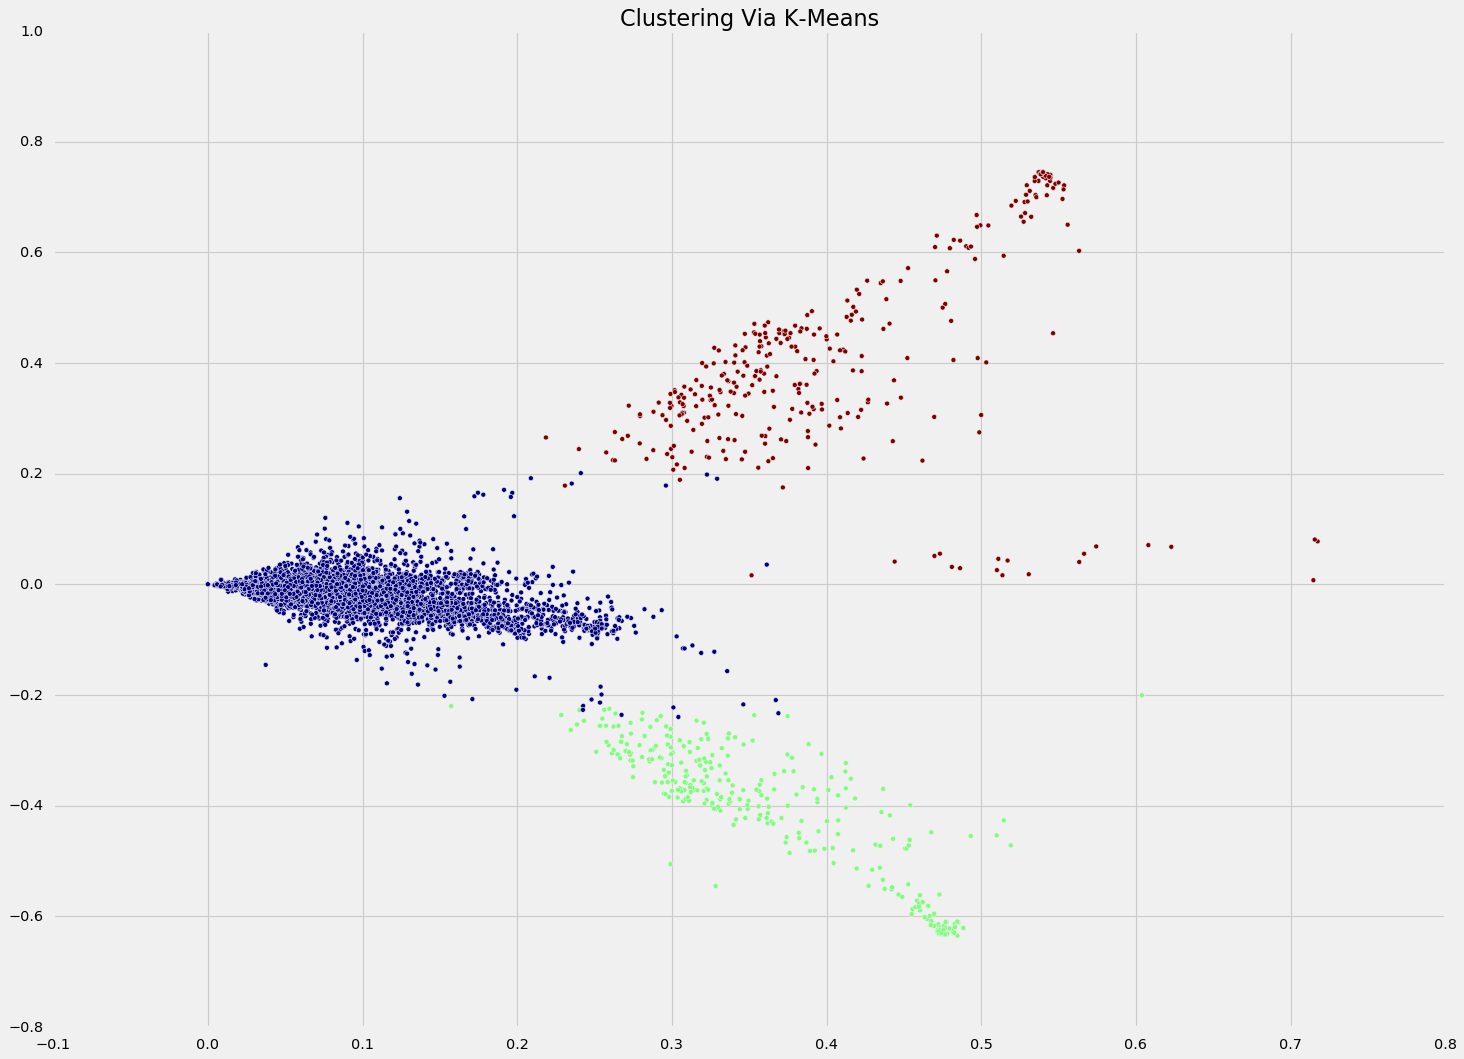

In [474]:
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from matplotlib import style

style.use('fivethirtyeight') 

plt.figure(figsize=(20,15))

# Calculate predicted values.
pred = KMeans(n_clusters=3, random_state=42).fit_predict(X_train_lsa)

# Plot the solution.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c = pred)
plt.title("Clustering Via K-Means")
plt.show()


In [353]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# Here we set the bandwidth. This function automatically derives a bandwidth
# number based on an inspection of the distances among points in the data.
bandwidth = estimate_bandwidth(X_train_lsa, quantile=0.2, n_samples=500)

# Declare and fit the model.
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=False)
ms.fit(X_train_lsa)

# Extract cluster assignments for each data point.
labels = ms.labels_

# Coordinates of the cluster centers.
cluster_centers = ms.cluster_centers_

# Count our clusters.
n_clusters_ = len(np.unique(labels))

print("Number of estimated clusters: {}".format(n_clusters_))

Number of estimated clusters: 1


### Let's take a look at Spectral Clustering

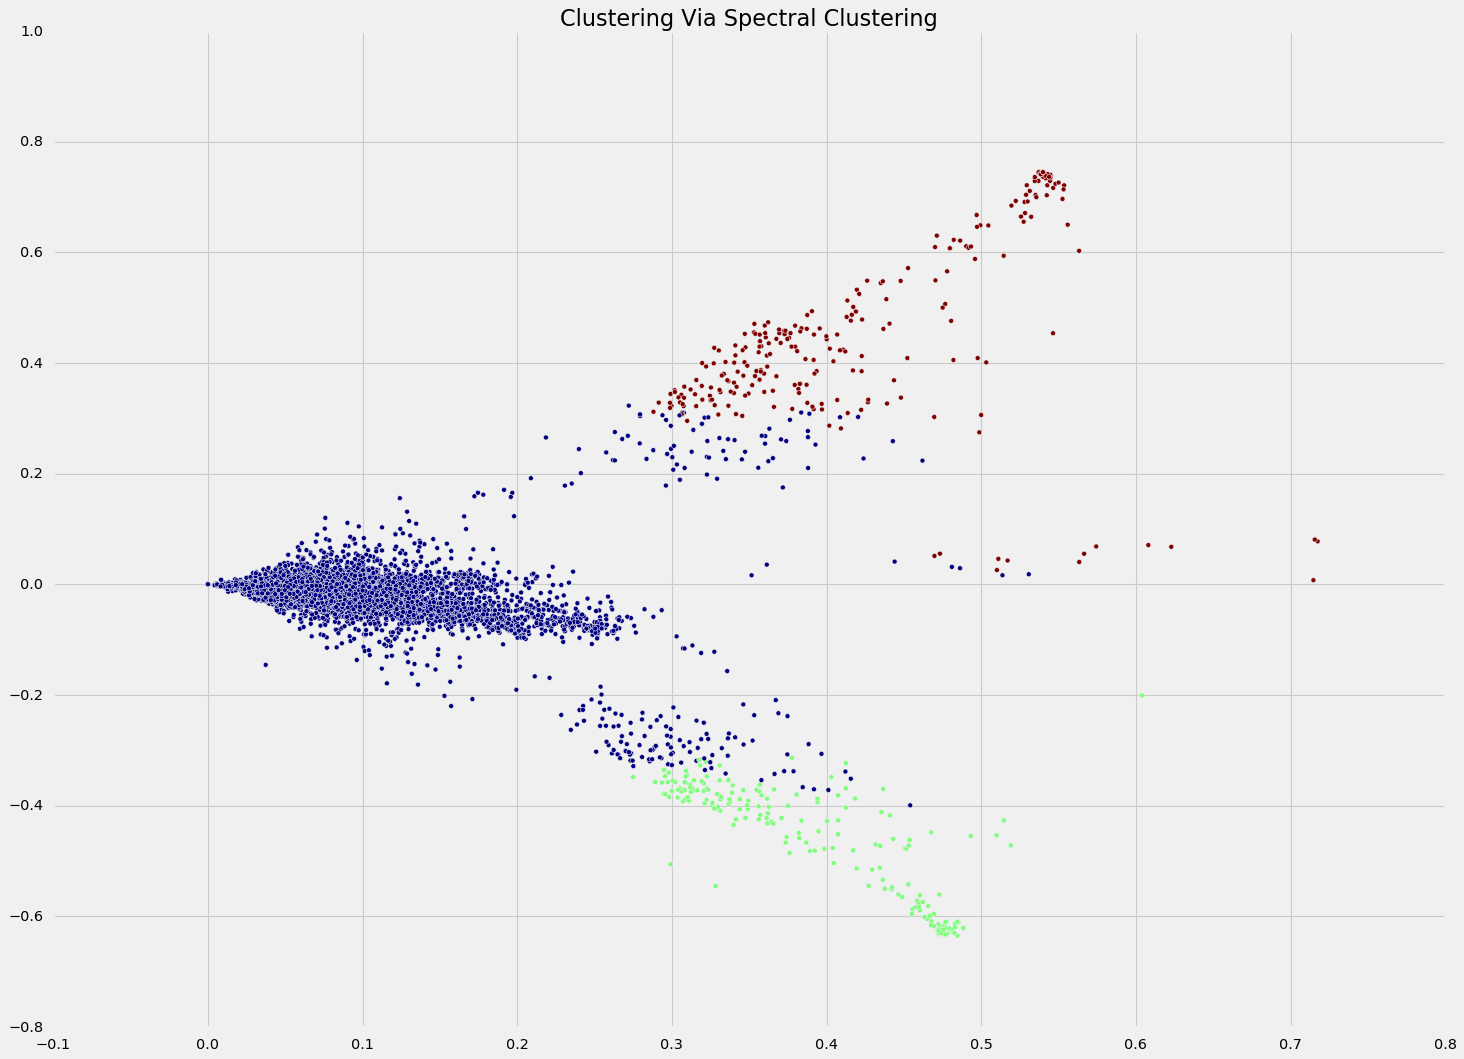

In [470]:
from sklearn.cluster import SpectralClustering
plt.figure(figsize=(20,15))
style.use('fivethirtyeight') 

# We know we're looking for three clusters.
n_clusters=3

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters)
sc.fit(X_train_lsa)

#Predicted clusters.
predict=sc.fit_predict(X_train_lsa)

#Graph results.
plt.scatter(X_train_lsa[:, 0], X_train_lsa[:, 1], c=predict)
plt.title("Clustering Via Spectral Clustering")
plt.show()


### Finally we'll look at Affinity Propagation (our slowest model)
Affinity propagation in general has a tendency to OVERSHOOT number of features, let's see how it does

In [437]:
#We are adjusting amount of data here to be able to run the model
#Affinity propagation is very memory intensive
#We are using about 75% of the rows here

lsadf = pd.DataFrame(X_train_lsa)
lsadf1 = lsadf[0:6000]
x_lsa_new = lsadf1.values
x_lsa_new

array([[ 0.0373724 , -0.14573729,  0.0530661 , ..., -0.00320863,
         0.01747835, -0.04411229],
       [ 0.08293329,  0.00374413,  0.03406494, ...,  0.05449544,
         0.04451407, -0.03566215],
       [ 0.06319495, -0.01607747,  0.028963  , ..., -0.11272214,
         0.18808275,  0.069718  ],
       ...,
       [ 0.05403405, -0.01571896,  0.06410049, ..., -0.03206616,
        -0.11872054, -0.01490463],
       [ 0.04359861, -0.01156474,  0.03966897, ..., -0.07790709,
         0.03005532,  0.02396662],
       [ 0.09001893, -0.06741623, -0.02562429, ..., -0.06811922,
        -0.11634223, -0.13847489]])

In [439]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

# Declare the model and fit it in one statement.
#This will take a while

af = AffinityPropagation(max_iter=500, convergence_iter=25).fit(x_lsa_new)
print('Done')

# Pull the number of clusters and cluster assignments for each data point.
cluster_centers_indices = af.cluster_centers_indices_
n_clusters_ = len(cluster_centers_indices)
labels = af.labels_

print('Estimated number of clusters: {}'.format(n_clusters_))

#Different amounts and parameters:
#2000 rows, max:300, conv:15,  [182]
#4000 rows, max:400, conv:25, [277]
#4000 rows, max:500, conv:25, [277]
#5000 rows, max:250, conv:25, [328]
#6000 rows, max:200, conv:25, [470]
#6000 rows, max:500, conv:25, [374]


Done
Estimated number of clusters: 374


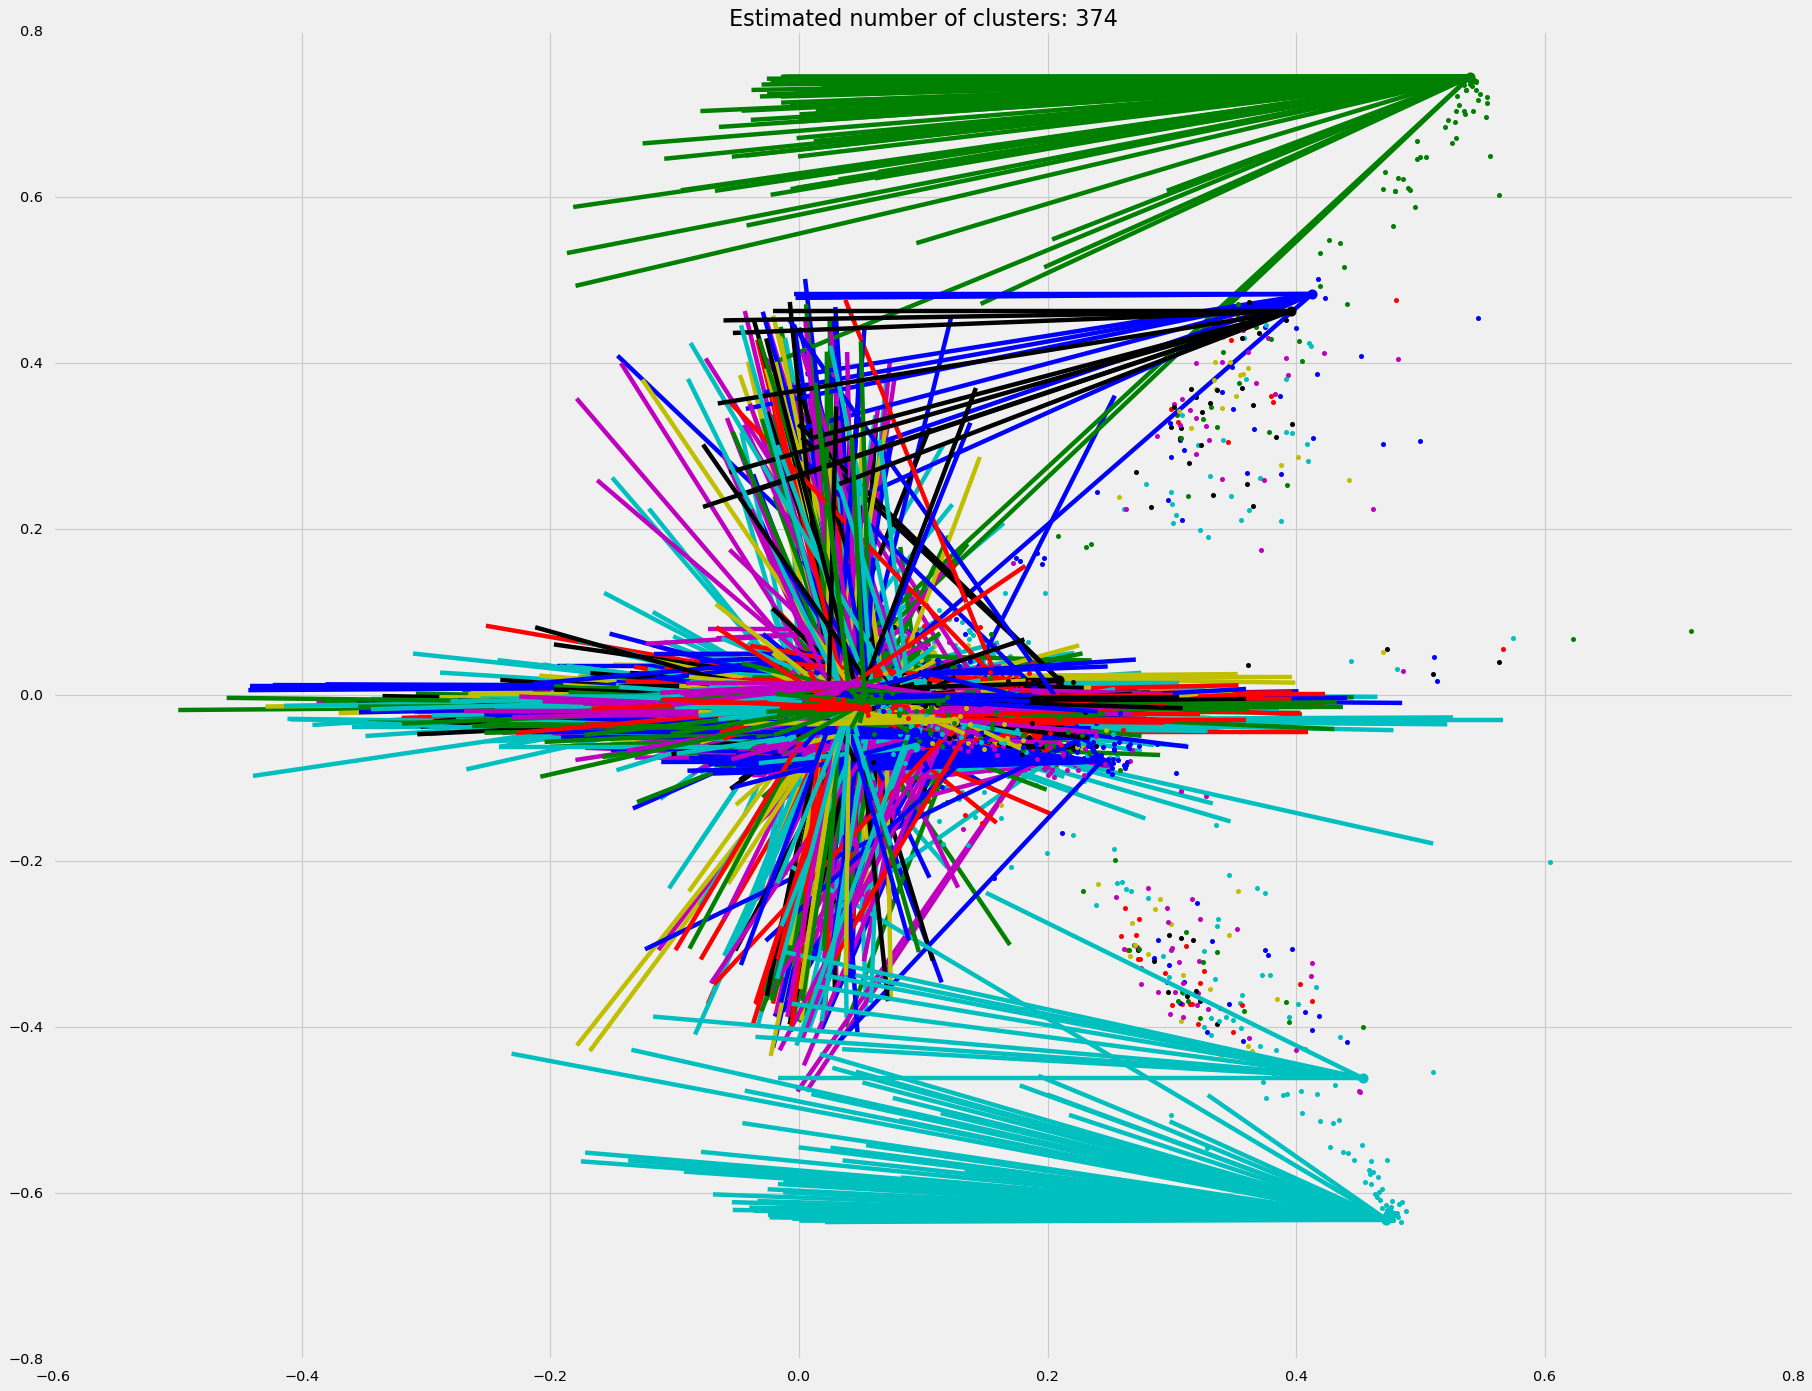

In [471]:
from itertools import cycle

plt.figure(figsize=(25,20))
style.use('fivethirtyeight') 
plt.figure(1)
plt.clf()

# Cycle through each cluster and graph them with a center point for the
# exemplar and lines from the exemplar to each data point in the cluster.
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = x_lsa_new[cluster_centers_indices[k]]
    plt.plot(x_lsa_new[class_members, 0], x_lsa_new[class_members, 1], col + '.')
    plt.plot(cluster_center[0],
             cluster_center[1],
             'o',
             markerfacecolor=col,
             markeredgecolor='k')
    for x in x_lsa_new[class_members]:
        plt.plot([cluster_center[0], x[-1]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: {}'.format(n_clusters_))
plt.show()